/home/caleb/src/VectorModel/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running vector opinion dynamics model
  Agents: 50
  Topics: 1 static + 0 dynamic
  Dimensions: 2
  Dynamic vectors per agent: 5
  Personality vectors per agent: 2
  Steps: 60
  Debug level: summary
  Seed: 0

STEP 0

Step Summary:
  Total messages in space: 5
  Avg messages received per agent: 3.56
  Avg messages sent per agent: 0.10

Agent Statistics (showing first 1 agents):

  Agent 1 (type: test):
    Messages received: 0
    Messages sent: 0
    Opinion changes:
      Topic 0: +0.347 → +0.347 (Δ+0.000)

Detailed Information (first 1 agents):

  ────────────────────────────────────────────────────────────────────────────
  Agent 1 (type: test)
  ────────────────────────────────────────────────────────────────────────────

  Messages Received (0 total, showing first 3):

  Messages Sent (0 total):

  Dynamic Vector Changes:

STEP 1

Step Summary:
  Total messages in space: 5
  Avg messages received per agent: 3.56
  Avg messages sent per agent: 0.10

Agent Statistics (showing first

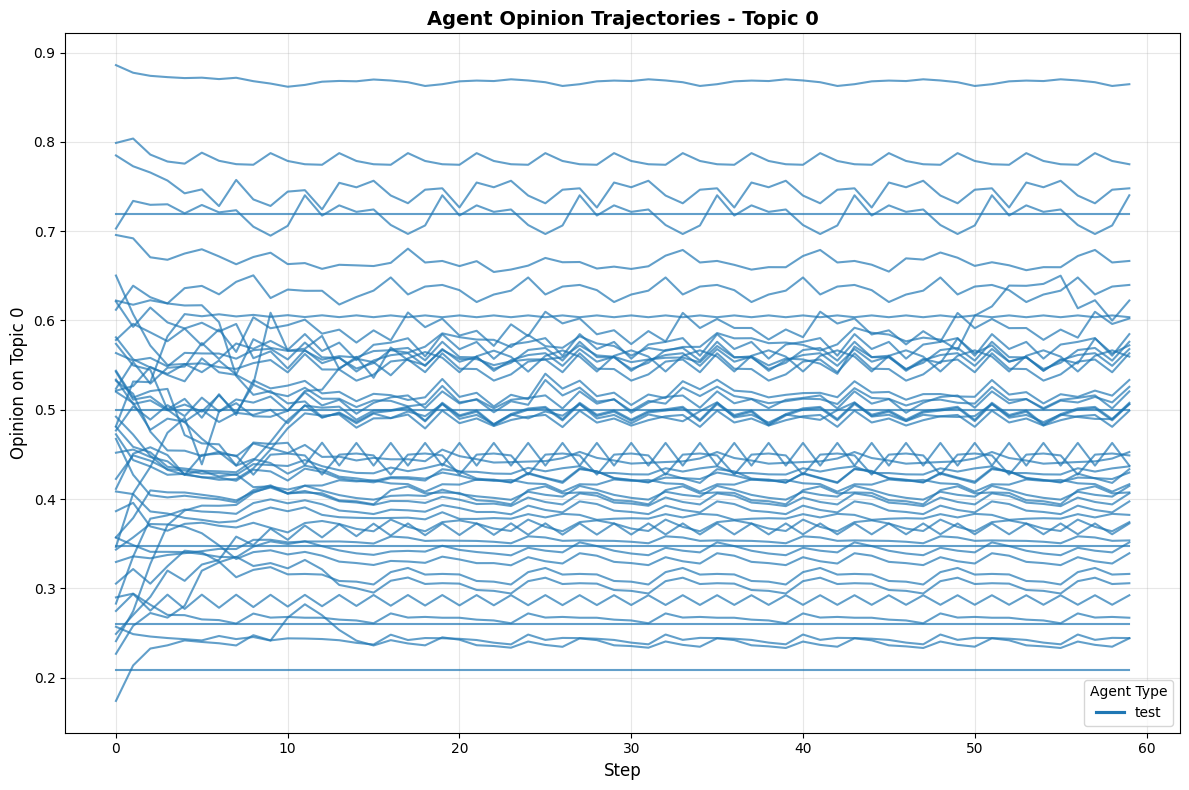

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'Agent Opinion Trajectories - Topic 0'}, xlabel='Step', ylabel='Opinion on Topic 0'>)

In [ ]:
import numpy as np
from vector_model import *
from analysis import *

from analysis import plot_opinion_trajectories, plot_all_topics, calculate_bipolarization

N_DIMS = 2             
N_DYN_VECS = 5           
N_PERS_VECS = 2          

N_STATIC_TOPICS = 1    
N_DYNAMIC_TOPICS = 0     
TOPIC_DECAY_RATE = 0.95 
TOPIC_REPLACE_THRESHOLD = 0.1  

N_AGENTS = 50

EPSILON_T_OP = 0.3       
EPSILON_R_OP = 0.1  
EPSILON_T_VEC = 0.3     
EPSILON_R_VEC = 0.1      
LAMBDA_PARAM = 1.0

MESSAGE_RATE = 1.5  
MAX_TARGETS = 4          

N_STEPS = 60
SIMILARITY_METHOD: SIMILARITY_METHODS = 'tanh'

SELECTOR_METHODS: List[MessageSelector.ALLOWED_METHODS] = ['select_all']
OPINION_SIMILARITY_THRESHOLD = 0.4
VECTOR_SIMILARITY_THRESHOLD = 0.4

PRODUCER_METHODS: List[MessageProducer.PRODUCER_METHODS] = ['opinionated']

DEBUG_LEVEL: DEBUG_LEVELS = 'summary'

SEED = 0


rng = np.random.default_rng(SEED)

topic_space = TopicSpace(
    n_dims=N_DIMS,
    n_static_topics=N_STATIC_TOPICS,
    n_dynamic_topics=N_DYNAMIC_TOPICS,
    decay_rate=TOPIC_DECAY_RATE,
    replacement_threshold=TOPIC_REPLACE_THRESHOLD,
    rng=rng
)

opinion_updater = OpinionUpdater(
    n_dims=N_DIMS,
    n_vecs=N_DYN_VECS,
    opinion_assimilative_method='closest',
    vector_assimilative_method='closest',
    opinion_repulsive_method='furthest',
    vector_repulsive_method='furthest',
    similarity_method=SIMILARITY_METHOD,
    epsilon_T_op=EPSILON_T_OP,
    epsilon_R_op=EPSILON_R_OP,
    epsilon_T_vec=EPSILON_T_VEC,
    epsilon_R_vec=EPSILON_R_VEC,
    lambda_param=LAMBDA_PARAM,
)

model = VectorModel(
    n_agents=N_AGENTS,
    topic_space=topic_space,
    opinion_updater=opinion_updater,
    n_dims=N_DIMS,
    n_dyn_vecs=N_DYN_VECS,
    n_pers_vecs=N_PERS_VECS,
    similarity_method=SIMILARITY_METHOD,
    data_collector=DataCollector('detailed', n_agents_to_track=1, n_messages_to_show=3),
)

for i in range(N_AGENTS):
    message_selector = MessageSelector(
        methods=SELECTOR_METHODS,
        similarity_method=SIMILARITY_METHOD,
        opinion_similarity_threshold=OPINION_SIMILARITY_THRESHOLD,
        vector_similarity_threshold=VECTOR_SIMILARITY_THRESHOLD,
        max_messages=None,
        rng=rng,
    )

    message_producer = MessageProducer(
        methods=PRODUCER_METHODS,
        similarity_method=SIMILARITY_METHOD,
        message_rate=MESSAGE_RATE,
        max_targets=MAX_TARGETS,
        n_max_messages=1,
        rng=rng,
        include_opinions=True,
        include_dyn_vecs=True,
        include_pers_vecs=True,
    )
    
    agent = VectorAgent(
        model=model,
        n_dims=N_DIMS,
        n_dyn_vecs=N_DYN_VECS,
        n_pers_vecs=N_PERS_VECS,
        message_selector=message_selector,
        message_producer=message_producer,
        similarity_method=SIMILARITY_METHOD,
        agent_type='test',
        rng=rng
        #rng=np.random.default_rng(seed=rng.integers(0, 1000, 1))
    )
    model.agents.add(agent)



print(f"Running vector opinion dynamics model")
print(f"  Agents: {N_AGENTS}")
print(f"  Topics: {N_STATIC_TOPICS} static + {N_DYNAMIC_TOPICS} dynamic")
print(f"  Dimensions: {N_DIMS}")
print(f"  Dynamic vectors per agent: {N_DYN_VECS}")
print(f"  Personality vectors per agent: {N_PERS_VECS}")
print(f"  Steps: {N_STEPS}")
print(f"  Debug level: {DEBUG_LEVEL}")
print(f"  Seed: {SEED}")

# Run the model
model.run(N_STEPS)

print("\n" + "="*80)
print("SIMULATION COMPLETE")
print("="*80)



if DEBUG_LEVEL != 'none':
    print(f"\nCollected debug data for {len(model.data_collector.step_data)} steps")
    
    agent_num = 2
    agent_opinions = []
    for step_data in model.data_collector.step_data:
        for agent_data in step_data:    
            if agent_data.agent_id == agent_num:
                agent_opinions.append(agent_data.opinions_after)
                break
    
    if agent_opinions:
        print(f"\nAgent {agent_num} opinion trajectory on topic 0:")
        for step, opinions in enumerate(agent_opinions):
            if opinions:
                print(f"  Step {step}: {opinions[0][1]:+.4f}")
                
bipolarization = calculate_bipolarization(model, 0)
print(f'FINAL BIPOLALIZATION: {bipolarization}')

plot_opinion_trajectories(
    model.data_collector, 
    topic_id=0,
)

#plot_all_topics(
#    model.data_collector,
#    n_topics=N_STATIC_TOPICS + N_DYNAMIC_TOPICS
#    )